In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gpflow.utilities import print_summary, set_trainable, to_default_float
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from sklearn.metrics import mean_squared_error, mean_absolute_error

import sys
sys.path.append('../../src')
from data_preparation import get_birth_data, separate_data
from useful_fun import plot_distribution, percentage_outof_CI

In [4]:
# load data

# whole dataset
data = get_birth_data()
x, y = separate_data(data, train_test=False)

# train/test split
df_train = pd.read_csv('../../data/train.csv')
x_train, y_train = separate_data(df_train)
df_test = pd.read_csv('../../data/test.csv')
x_test, y_test = separate_data(df_test)

# get date for x-axis in plots
def get_xticks(data):
    idss = []; yrs = []
    yr = 1969
    for i in range(20):
        df = data.loc[data.year == yr+i]
        yrs.append(yr+i)
        idss.append(df.index[0])
    return idss, yrs
pos, labels = get_xticks(data)

2022-08-07 19:54:27.634105: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-07 19:54:28.217487: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9646 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5


# Simple one-latent function model

        y = f(x) + e
        f = GP(0, RBF)

        l = InvGama()
        sigma = Gamma()

2022-08-07 10:43:44.627654: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-08-07 10:43:51.722833: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x801c540


Epoch 25 - Loss:  4738.0530


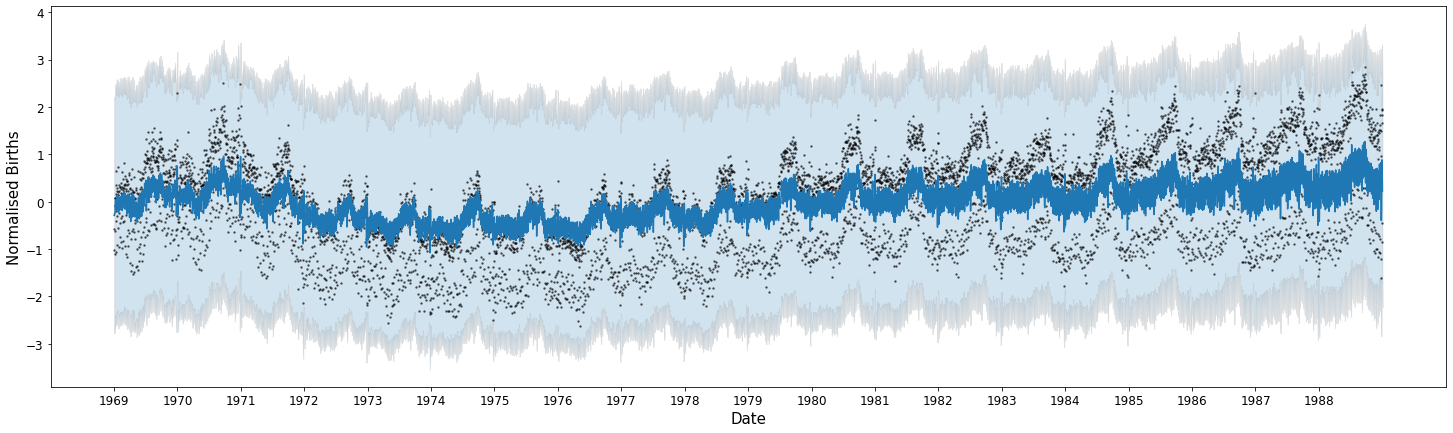

Fitted values MSE:  0.45294772398699656
ELBO:  -4738.05295640714
percentage out of CI:  0.0
Epoch 50 - Loss:  4603.2903


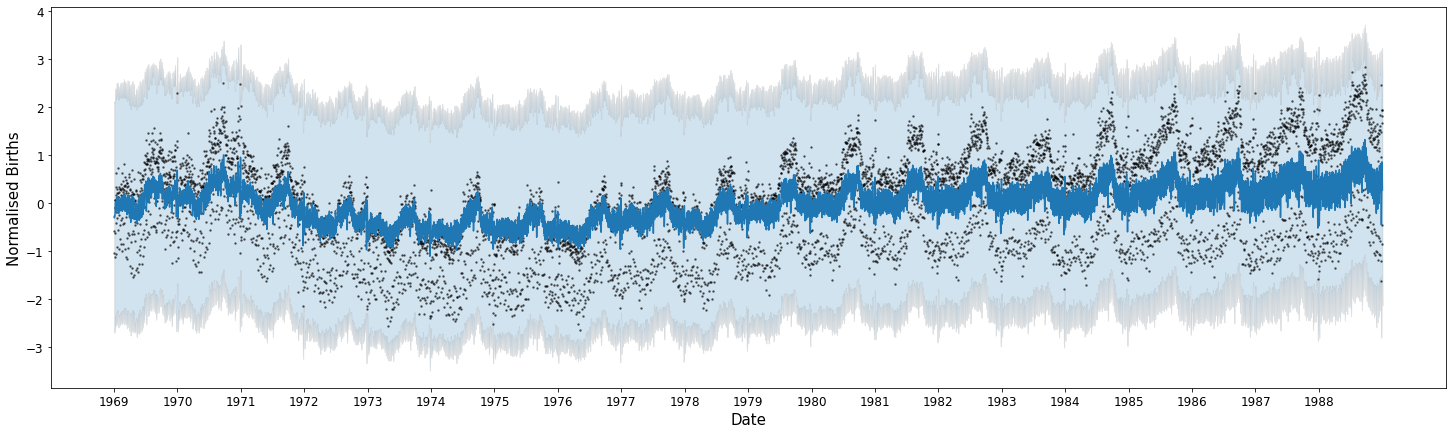

Fitted values MSE:  0.4451658054453016
ELBO:  -4603.290296737387
percentage out of CI:  0.0


In [3]:
# build model & compute fitted values

kernel = gpflow.kernels.RBF()
likelihood = gpflow.likelihoods.Gaussian()

M = 3000  
Z = np.linspace(x.numpy().min(), x.numpy().max(), M)[:, None]

model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=None, num_data=M)

data = (x, y)
loss_fn = model.training_loss_closure(data) 

gpflow.utilities.set_trainable(model.q_mu, False)
gpflow.utilities.set_trainable(model.q_sqrt, False)
set_trainable(model.likelihood.variance, False)

variational_vars = [(model.q_mu, model.q_sqrt)]
natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
adam_vars = model.trainable_variables
adam_opt = tf.optimizers.Adam(0.01)

@tf.function
def optimisation_step():
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)

epochs = 50
log_freq = 25

for epoch in range(1, epochs + 1):
    optimisation_step()

    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
        mean, var = model.predict_y(x)
        plot_distribution(x, y, mean, var, pos, labels)
        print('Fitted values MSE: ', mean_squared_error(y, mean))
        print('ELBO: ', model.elbo((x,y)).numpy())
        print('percentage out of CI: ', percentage_outof_CI(y, mean, var))


print_summary(model, fmt='notebook')

CI too big?

Add priors to hyperparameters

Epoch 25 - Loss:  4739.4139


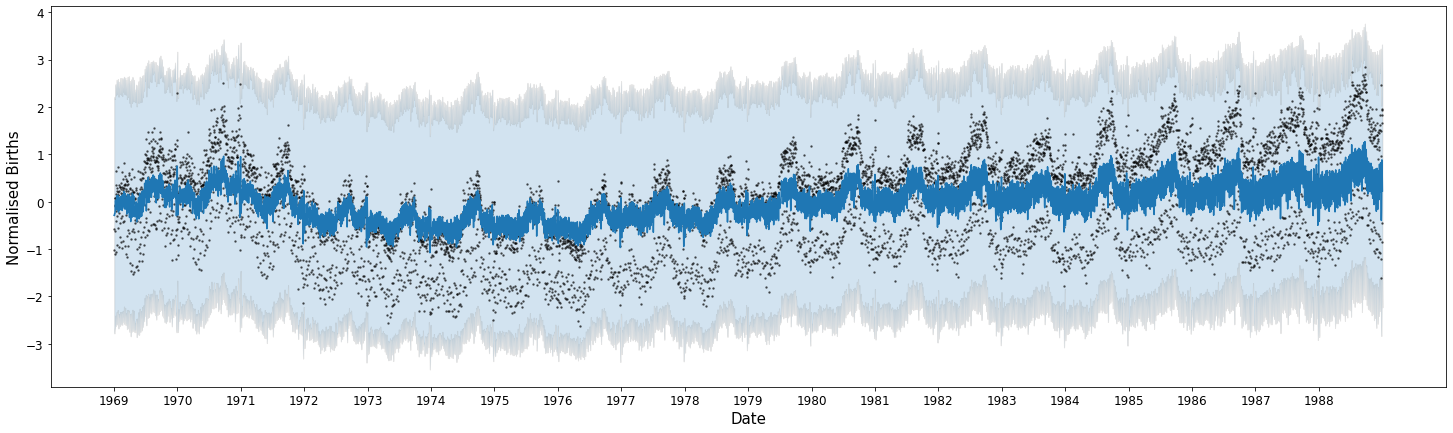

Fitted values MSE:  0.452953722491947
ELBO:  -4738.041529318717
percentage out of CI:  0.0
Epoch 50 - Loss:  4604.5353


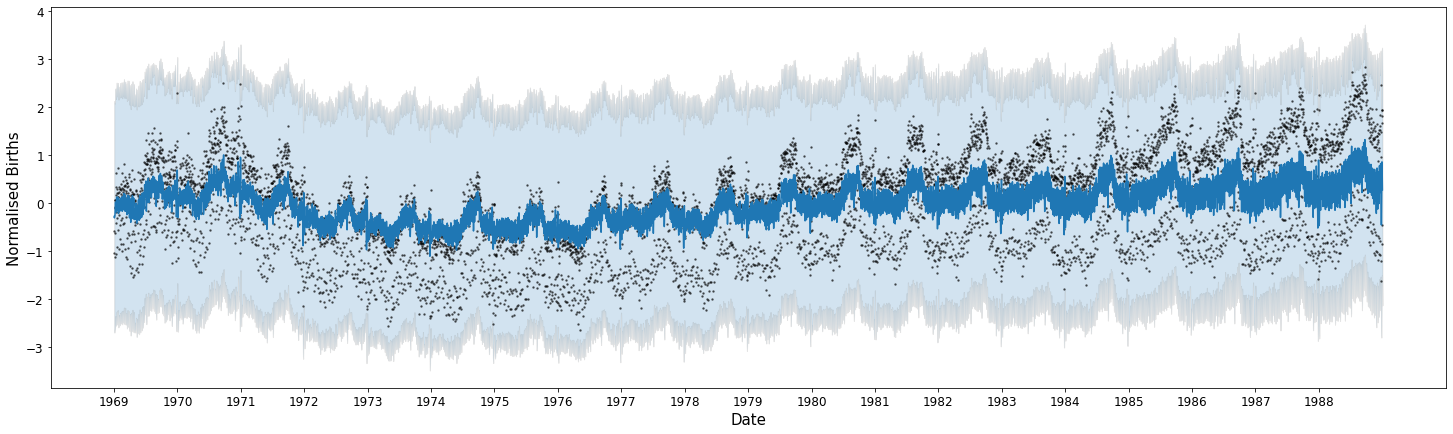

Fitted values MSE:  0.44518807278050043
ELBO:  -4603.273328094826
percentage out of CI:  0.0


In [4]:
# build model & compute fitted values

kernel = gpflow.kernels.RBF()
likelihood = gpflow.likelihoods.Gaussian()

M = 3000  
Z = np.linspace(x.numpy().min(), x.numpy().max(), M)[:, None]

model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)

data = (x, y)
loss_fn = model.training_loss_closure(data) 

gpflow.utilities.set_trainable(model.q_mu, False)
gpflow.utilities.set_trainable(model.q_sqrt, False)
set_trainable(model.likelihood.variance, False)

# adding priors
model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(2), to_default_float(3))
model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

variational_vars = [(model.q_mu, model.q_sqrt)]
natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
adam_vars = model.trainable_variables
adam_opt = tf.optimizers.Adam(0.01)

@tf.function
def optimisation_step():
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)

epochs = 50
log_freq = 25

for epoch in range(1, epochs + 1):
    optimisation_step()

    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
        mean, var = model.predict_y(x)
        plot_distribution(x, y, mean, var, pos, labels)
        print('Fitted values MSE: ', mean_squared_error(y, mean))
        print('ELBO: ', model.elbo((x,y)).numpy())
        print('percentage out of CI: ', percentage_outof_CI(y, mean, var))

print_summary(model, fmt='notebook')

Change starting conditions

Epoch 25 - Loss:  4296.8695


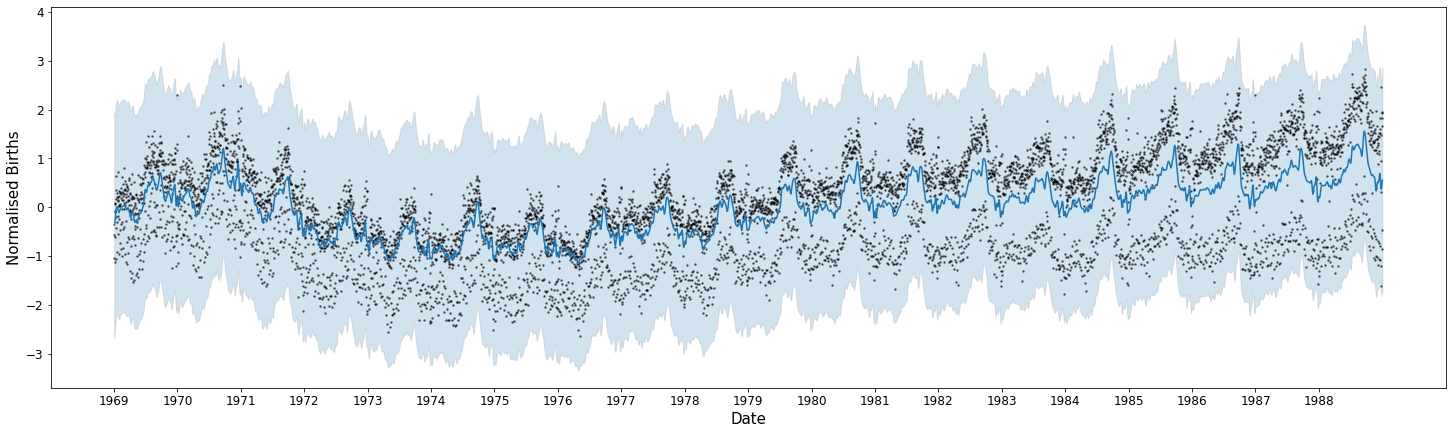

Fitted values MSE:  0.5486517979974698
ELBO:  -4292.968232328029
Epoch 50 - Loss:  4253.9088


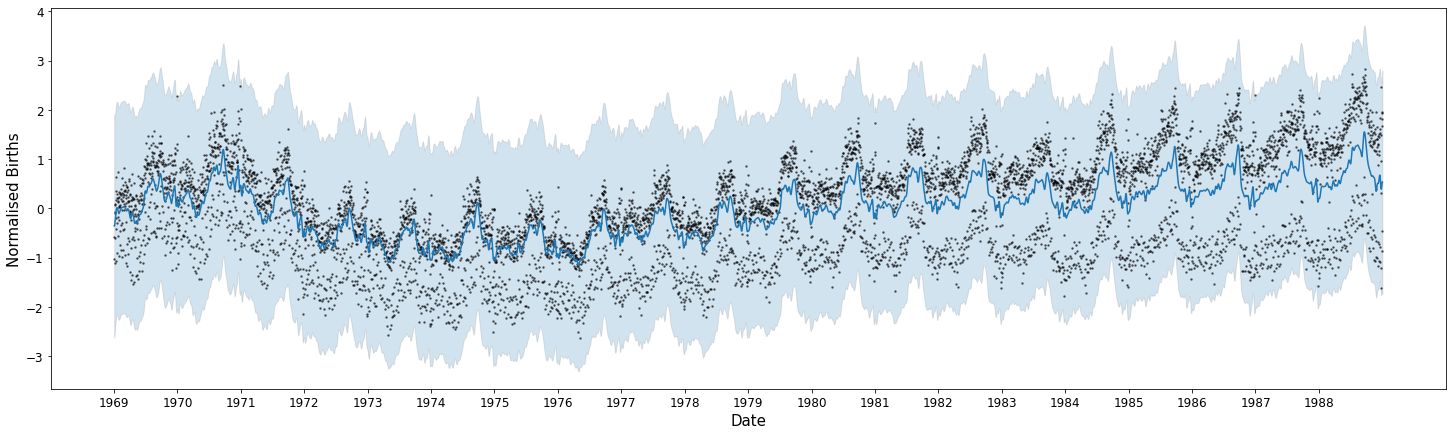

Fitted values MSE:  0.5500028510642093
ELBO:  -4250.082525218106


In [14]:
kernel = gpflow.kernels.RBF(lengthscales=5)
likelihood = gpflow.likelihoods.Gaussian()

M = 3000  
Z = np.linspace(x.numpy().min(), x.numpy().max(), M)[:, None]

model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)

data = (x, y)
loss_fn = model.training_loss_closure(data) 

gpflow.utilities.set_trainable(model.q_mu, False)
gpflow.utilities.set_trainable(model.q_sqrt, False)
set_trainable(model.likelihood.variance, False)

# adding priors
model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(2), to_default_float(3))
model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

variational_vars = [(model.q_mu, model.q_sqrt)]
natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
adam_vars = model.trainable_variables
adam_opt = tf.optimizers.Adam(0.01)

@tf.function
def optimisation_step():
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)

epochs = 50
log_freq = 25

for epoch in range(1, epochs + 1):
    optimisation_step()

    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
        mean, var = model.predict_y(x)
        plot_distribution(x, y, mean, var, pos, labels)
        print('Fitted values MSE: ', mean_squared_error(y, mean))
        print('ELBO: ', model.elbo((x,y)).numpy())
        print('percentage out of CI: ', percentage_outof_CI(y, mean, var))

print_summary(model, fmt='notebook')

Again we see these models are sensitive to starting values.

Need to look at train test for fair comparison of which is better.

-------------------------------------------------------------

# Train / Test split: model selection

Assess which kernel helps represent the data best.

    MSE, MAE, Likelihood

Since we have found that the starting point of kernel parameters affects the fit significantly, we will first select the kernel and then run an analysis to find optimal starting conditions for hyperparameters.

In [4]:
def optimise_predict_model(model, M=3000):
    train_data = (x_train, y_train)
    loss_fn = model.training_loss_closure(train_data) 

    gpflow.utilities.set_trainable(model.q_mu, False)
    gpflow.utilities.set_trainable(model.q_sqrt, False)

    variational_vars = [(model.q_mu, model.q_sqrt)]
    natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
    adam_vars = model.trainable_variables
    adam_opt = tf.optimizers.Adam(0.01)

    @tf.function
    def optimisation_step():
        natgrad_opt.minimize(loss_fn, variational_vars)
        adam_opt.minimize(loss_fn, adam_vars)

    epochs = 50
    log_freq = 50

    for epoch in range(1, epochs + 1):
        optimisation_step()

        # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
        if epoch % log_freq == 0 and epoch > 0:
            print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
            mean_train, var_train = model.predict_f(x_train)
            print('Train')
            plot_distribution(x_train, y_train, mean_train, var_train, pos, labels, legend=False)

    # predict
    mean_test, var_test = model.predict_f(x_test)
    print('Test')
    plot_distribution(x_test, y_test, mean_test, var_test, pos, labels)

    print('train ELBO, MSE, MAE: ', model.elbo((x_train,y_train)).numpy(), mean_squared_error(y_train, mean_train), mean_absolute_error(y_train, mean_train))
    print('test ELBO, MSE, MAE: ', model.elbo((x_test,y_test)).numpy(), mean_squared_error(y_test, mean_test), mean_absolute_error(y_test, mean_test))
    print('percentage out of CI (train, test): ', percentage_outof_CI(y_train, mean_train, var_train), percentage_outof_CI(y_test, mean_test, var_test))

    print_summary(model, fmt='notebook')

The models consist of a single latent function, untrainable noise variance (justify), hyperparameters with priors.

Epoch 50 - Loss:  4144.7244
Train


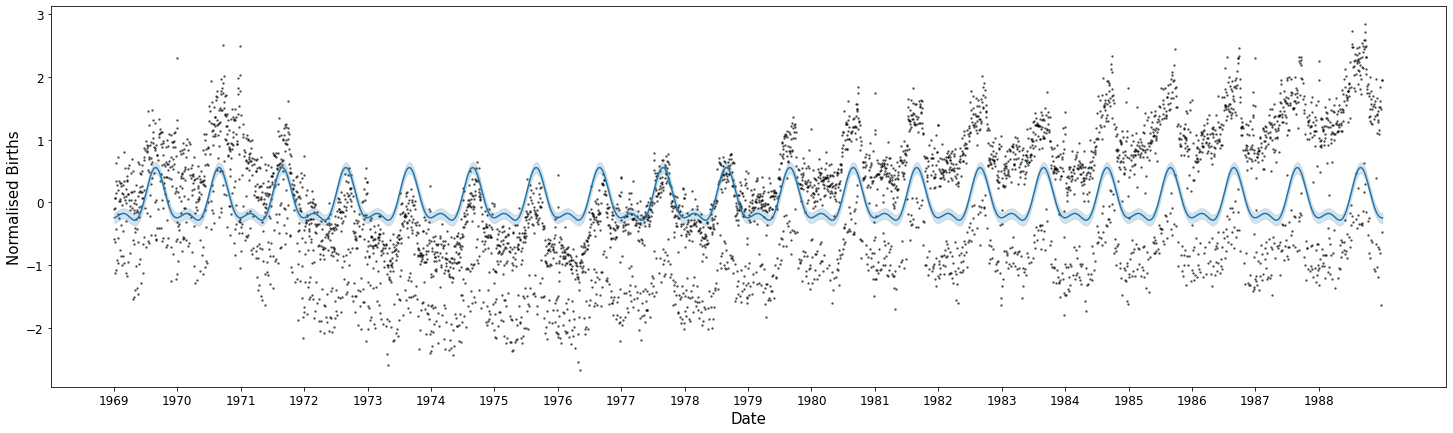

Test


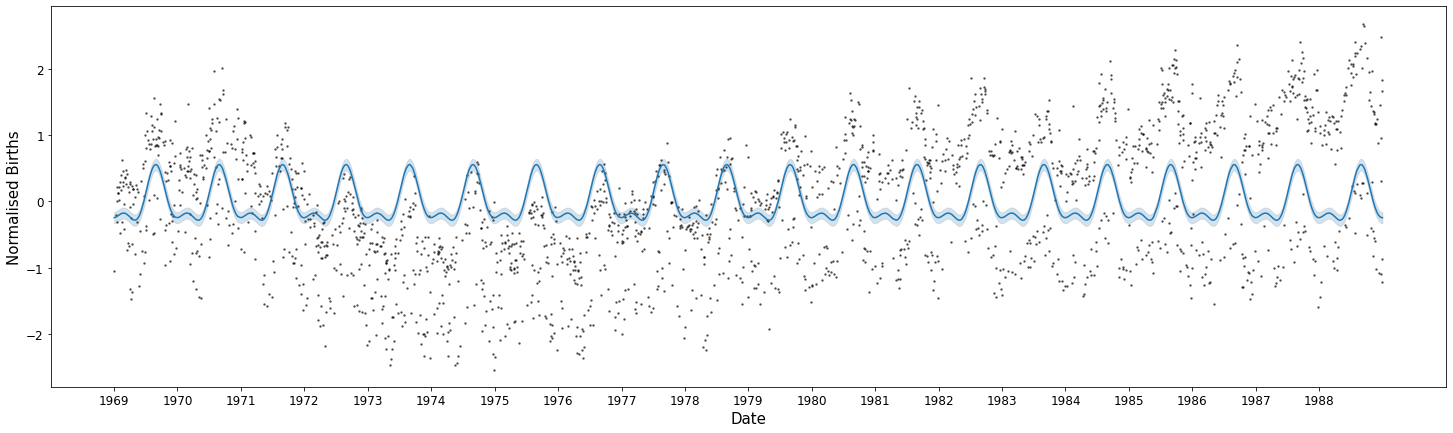

train ELBO, MSE, MAE:  -4143.7459035101165 0.9148080153948241 0.8164123619030597
test ELBO, MSE, MAE:  -4165.410181362453 0.9292450774458814 0.826864210918036
percentage out of CI (train, test):  96.10796010170155 96.16788321167883


--------------------------------------------------------
Epoch 50 - Loss:  4613.3459
Train


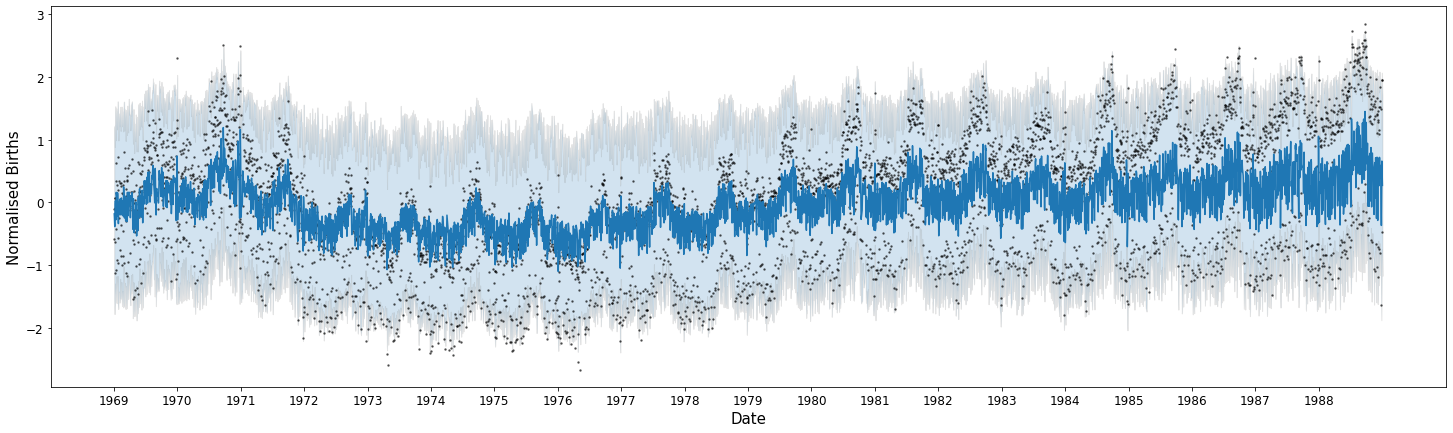

Test


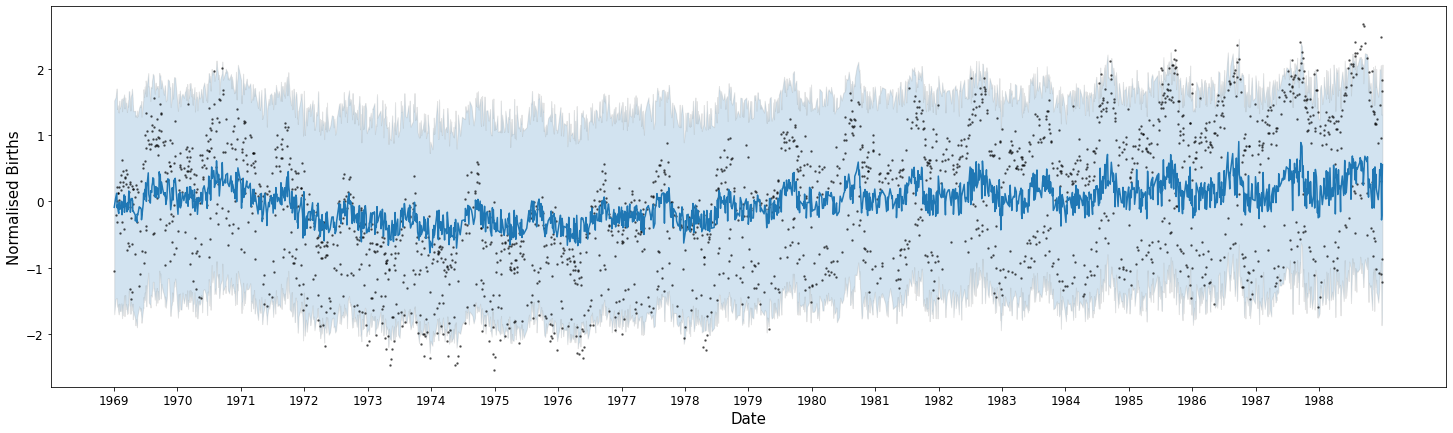

train ELBO, MSE, MAE:  -4611.732732315487 0.42582577502511065 0.5478604577487718
test ELBO, MSE, MAE:  -5282.174941521904 0.7514760889825538 0.7326139590023499
percentage out of CI (train, test):  1.4668492079014277 5.337591240875912


--------------------------------------------------------
Epoch 50 - Loss:  4517.2507
Train


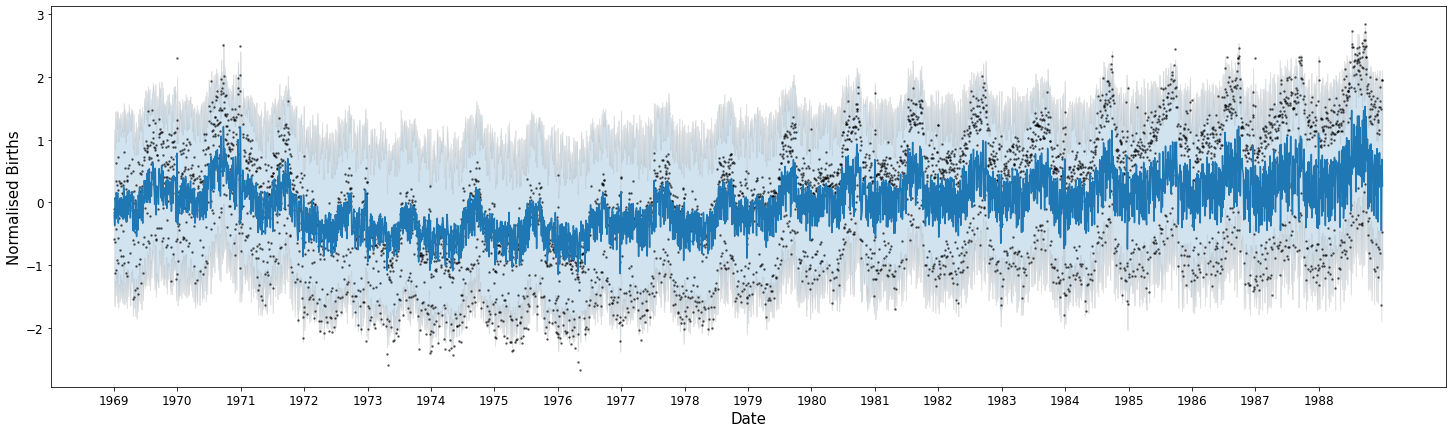

Test


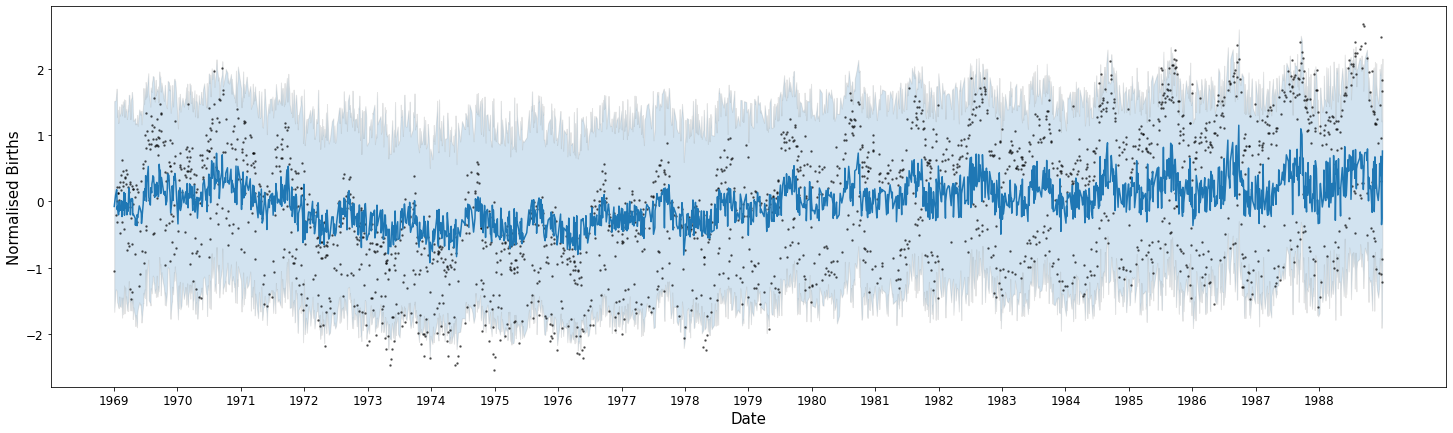

train ELBO, MSE, MAE:  -4515.646150393144 0.3963645564662199 0.5254731665010439
test ELBO, MSE, MAE:  -5195.882097684635 0.7179364604168349 0.7139601748449784
percentage out of CI (train, test):  2.034030901623313 6.25


--------------------------------------------------------


In [7]:
# Kernel MODEL SELECTION
kernel_list = [gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25), gpflow.kernels.Matern32(), gpflow.kernels.RBF()]

for i in range(len(kernel_list)):
    print(kernel_list[i])

    kernel = kernel_list[i]

    Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
    model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
    set_trainable(model.likelihood.variance, False)

    if i == 0:
        set_trainable(model.kernel.period, False)
        model.kernel.base_kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(3), to_default_float(2))
        model.kernel.base_kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))
    else:
        model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(3), to_default_float(2))
        model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))
    
    optimise_predict_model(model)
    print('--------------------------------------------------------')

The kernel with best performance: RBF. Although, Matern52 performs similar. BUT, the models seem to be overfitting. Maybe lower the epochs...

Now, we would carry out the sensitivity analysis done before but on the train test set.

Starting Values l:  1
Epoch 50 - Loss:  4517.7283
Train


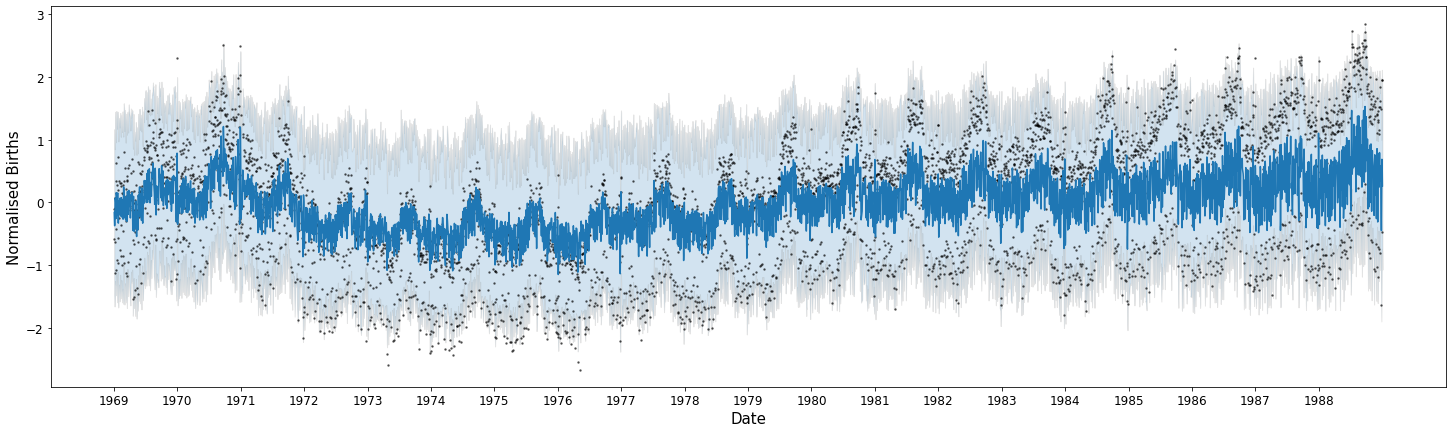

Test


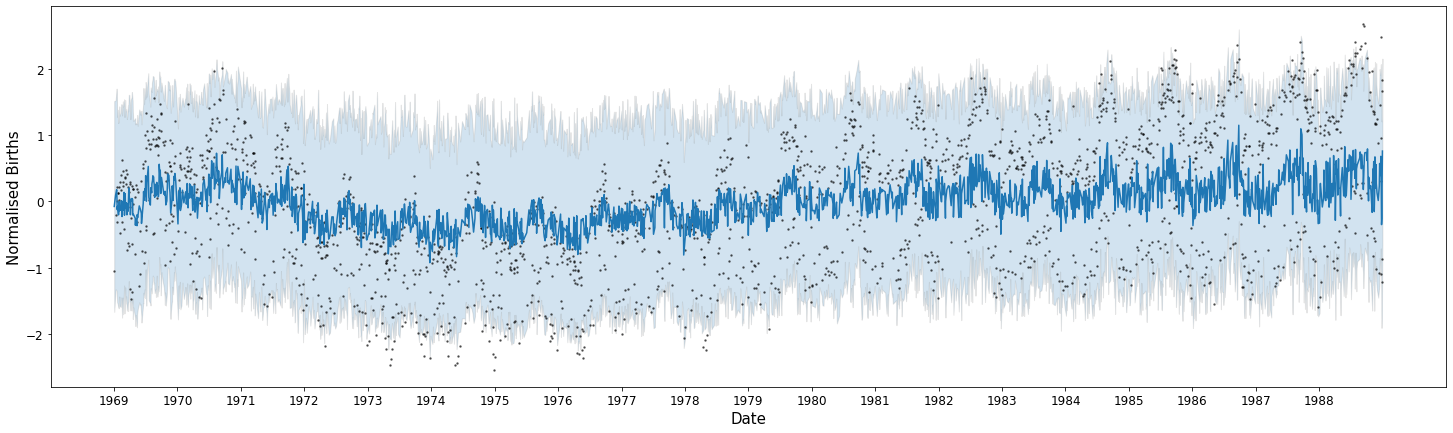

train ELBO, MSE, MAE:  -4515.624772308348 0.3963616270629404 0.5254711303730399
test ELBO, MSE, MAE:  -5195.8444448917235 0.7179266310704205 0.7139553209139362
percentage out of CI (train, test):  2.034030901623313 6.25


--------------------------------------------------------
Starting Values l:  5
Epoch 50 - Loss:  4218.8861
Train


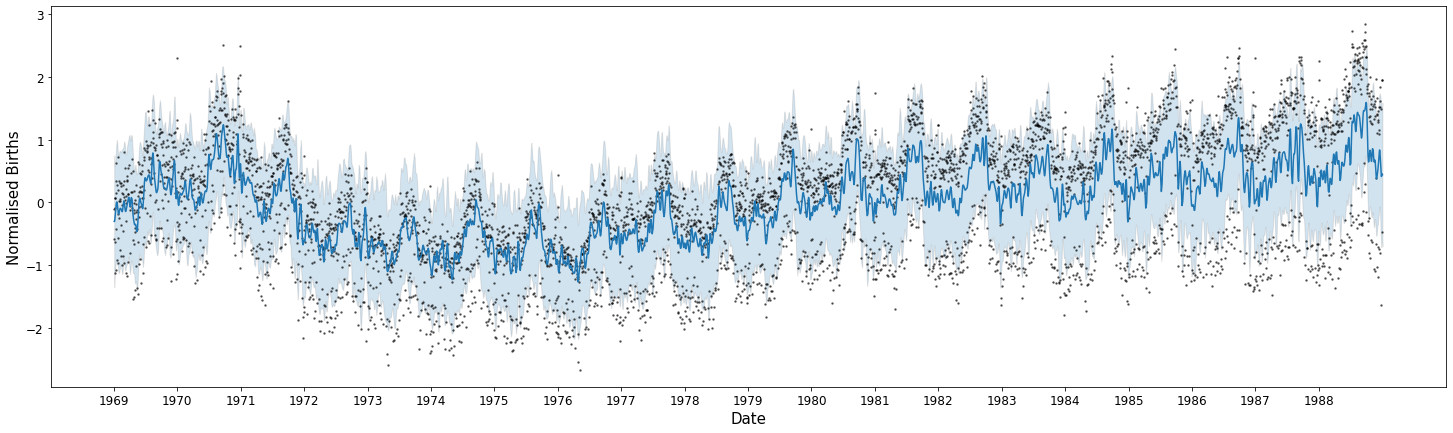

Test


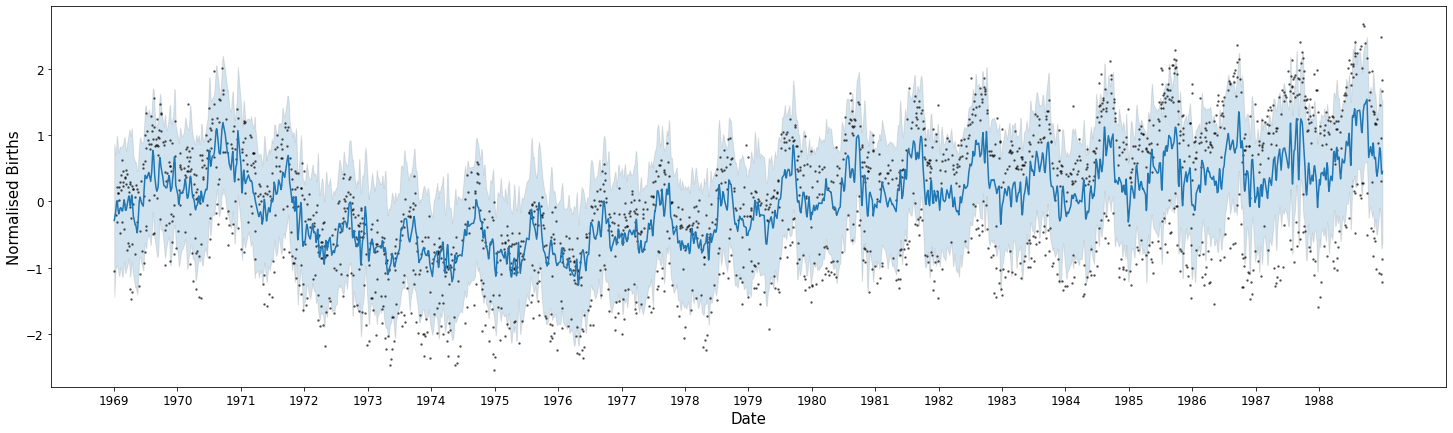

train ELBO, MSE, MAE:  -4215.2011139334545 0.5223393115360271 0.6058988468412954
test ELBO, MSE, MAE:  -4518.188732853362 0.6927887628951789 0.700979943140881
percentage out of CI (train, test):  24.467044787795814 29.1514598540146


--------------------------------------------------------
Starting Values l:  7
Epoch 50 - Loss:  4132.6872
Train


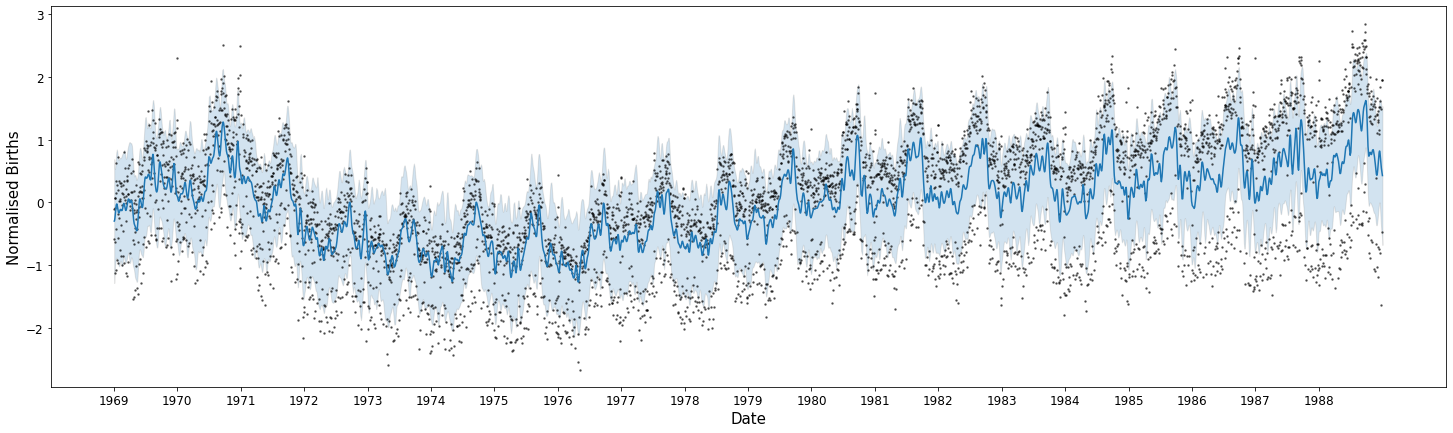

Test


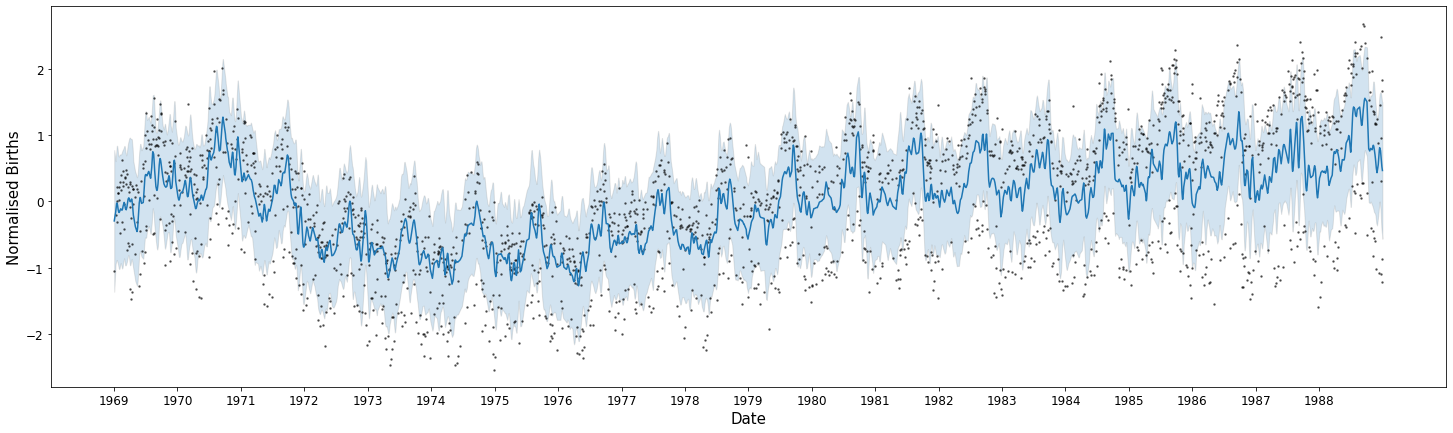

train ELBO, MSE, MAE:  -4128.576820839988 0.526183998310729 0.6090823986996362
test ELBO, MSE, MAE:  -4360.693240603621 0.6604593956534132 0.6846454084395107
percentage out of CI (train, test):  29.70858595736358 33.85036496350365


--------------------------------------------------------
Starting Values l:  10
Epoch 50 - Loss:  4046.5955
Train


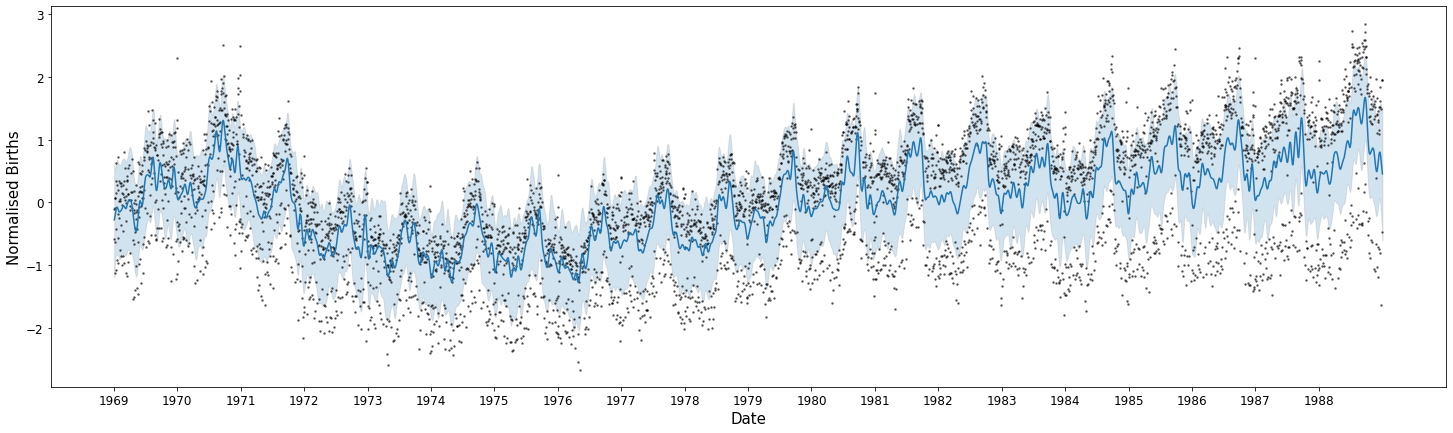

Test


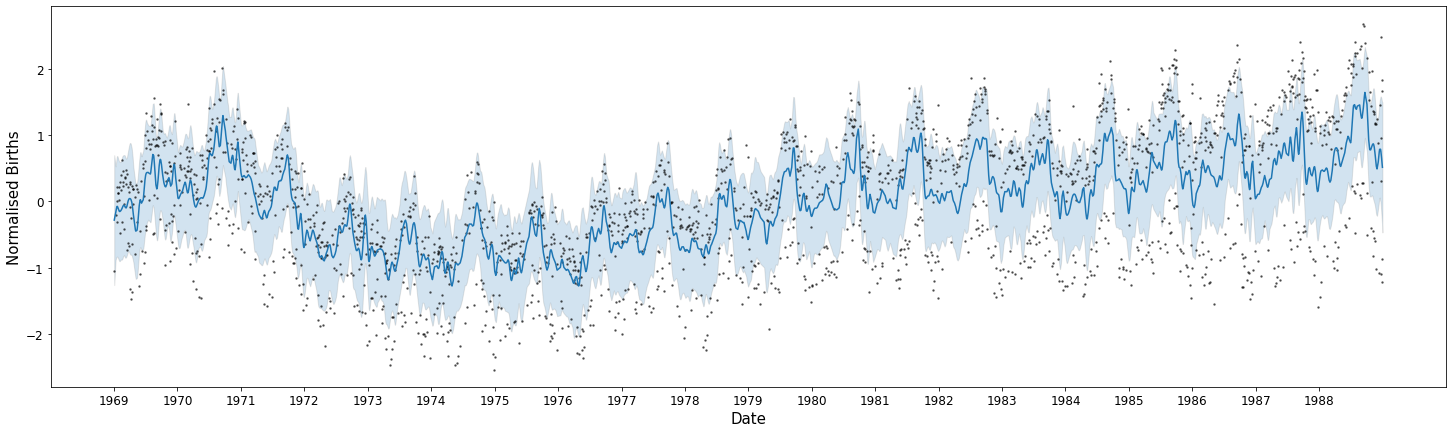

train ELBO, MSE, MAE:  -4042.009134688427 0.5297143904501443 0.6126368829025487
test ELBO, MSE, MAE:  -4216.540859217715 0.6335795458135407 0.6712581199639973
percentage out of CI (train, test):  35.39996088402112 38.64051094890511


--------------------------------------------------------


In [12]:
starting_values_l = [1, 5, 7, 10]

for l in starting_values_l:
    print('Starting Values l: ', l)
    kernel = gpflow.kernels.RBF(lengthscales = l, variance = 1)
    Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
    model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
    set_trainable(model.likelihood.variance, False)
    
    model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(0.5), to_default_float(1))
    model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

    optimise_predict_model(model)
    print('--------------------------------------------------------')

Starting conditions 1,1 seem to be overfitting. 5,1 although has a worse train mse, it is closer to test mse, less overfitting.

Try 1,1 but less epochs.

Starting Values (l, v):  10 1
Epoch 20 - Loss:  4016.9012
Epoch 40 - Loss:  3971.3598
Epoch 60 - Loss:  3948.0477
Epoch 80 - Loss:  3930.0529
Epoch 100 - Loss:  3915.0845
Train


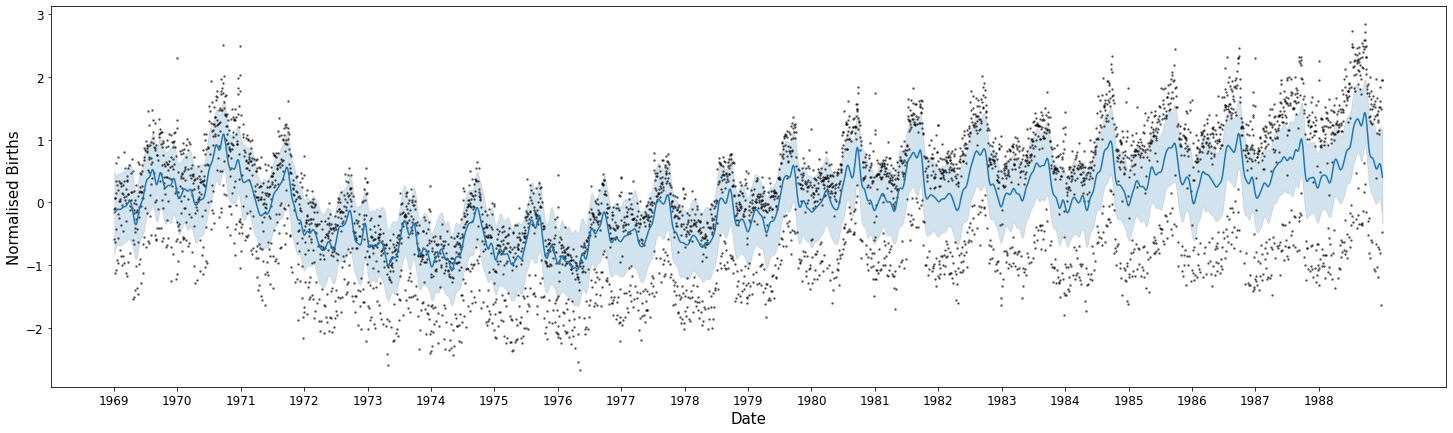

Epoch 120 - Loss:  3902.3034
Epoch 140 - Loss:  3891.2182
Epoch 160 - Loss:  3881.4858
Epoch 180 - Loss:  3872.8538
Epoch 200 - Loss:  3865.1326
Test


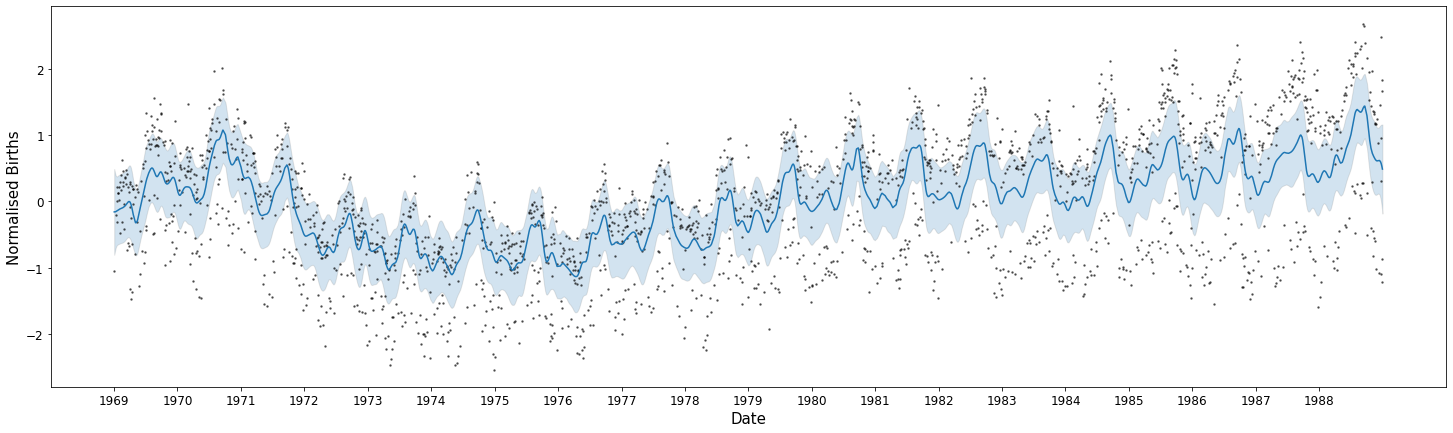

train ELBO, MSE, MAE:  -3860.1474899854566 0.5544692064041653 0.6270815803946922
test ELBO, MSE, MAE:  -3946.015151910794 0.6057635060413048 0.655983157256647
percentage out of CI (train, test):  51.67220809700763 56.75182481751825


In [14]:
print('Starting Values (l, v): ', 10, 1)
kernel = gpflow.kernels.RBF(lengthscales = 7, variance = 1)
M = 3000
Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
set_trainable(model.likelihood.variance, False)
model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(0.5), to_default_float(1))
model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

train_data = (x_train, y_train)
loss_fn = model.training_loss_closure(train_data) 

gpflow.utilities.set_trainable(model.q_mu, False)
gpflow.utilities.set_trainable(model.q_sqrt, False)

variational_vars = [(model.q_mu, model.q_sqrt)]
natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
adam_vars = model.trainable_variables
adam_opt = tf.optimizers.Adam(0.1)

@tf.function
def optimisation_step():
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)

epochs = 200
log_freq = 20

for epoch in range(1, epochs + 1):
    optimisation_step()

    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
        if epoch == 100:
            mean_train, var_train = model.predict_f(x_train)
            print('Train')
            plot_distribution(x_train, y_train, mean_train, var_train, pos, labels, legend=False)

# predict
mean_test, var_test = model.predict_f(x_test)
print('Test')
plot_distribution(x_test, y_test, mean_test, var_test, pos, labels)

# evaluate
print('train ELBO, MSE, MAE: ', model.elbo((x_train,y_train)).numpy(), mean_squared_error(y_train, mean_train), mean_absolute_error(y_train, mean_train))
print('test ELBO, MSE, MAE: ', model.elbo((x_test,y_test)).numpy(), mean_squared_error(y_test, mean_test), mean_absolute_error(y_test, mean_test))
print('percentage out of CI (train, test): ', percentage_outof_CI(y_train, mean_train, var_train), percentage_outof_CI(y_test, mean_test, var_test))

print_summary(model, fmt='notebook')

_________________

Plot for write up

Epoch 20 - Loss:  4682.1905
Epoch 40 - Loss:  4557.5528
Epoch 60 - Loss:  4485.6346
Epoch 80 - Loss:  4436.1857
Epoch 100 - Loss:  4399.2020
Train


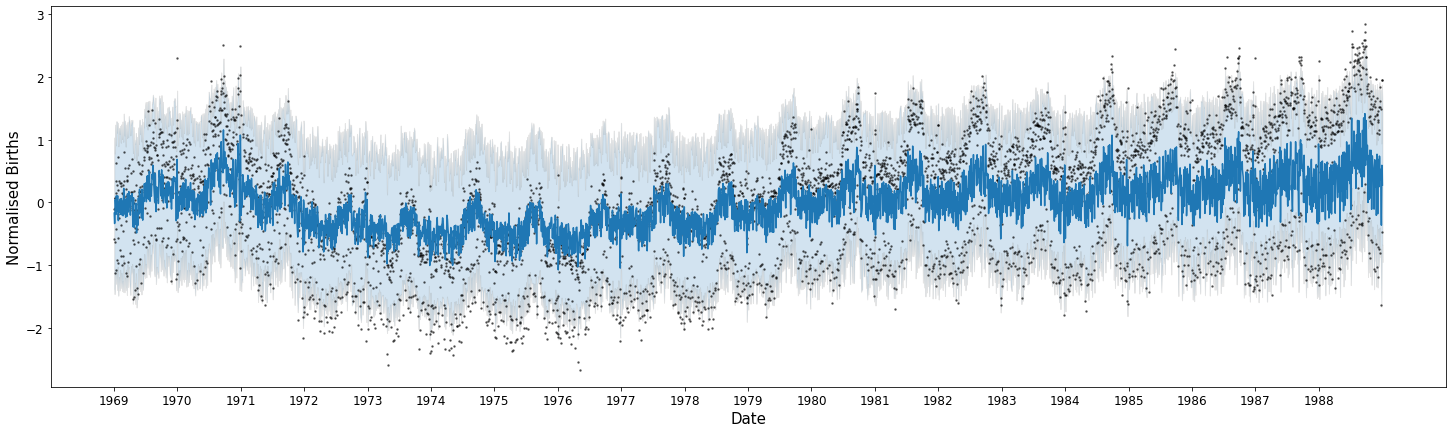

Test


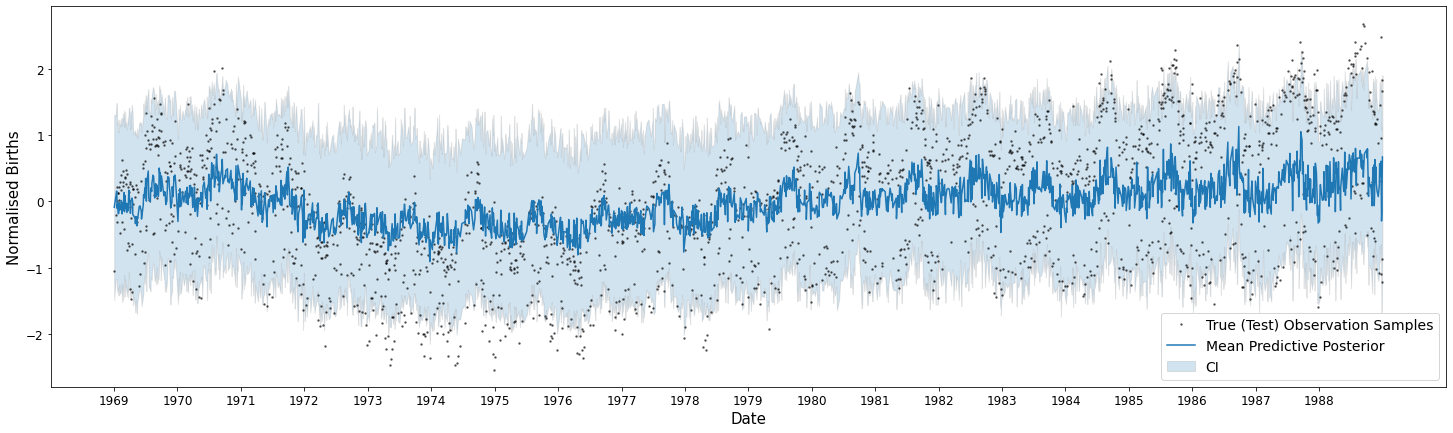

train ELBO, MSE, MAE:  -4397.202587573558 0.4402369687412963 0.5542282682161116
test ELBO, MSE, MAE:  -4961.5362556201835 0.724804026873664 0.7183912116470241
percentage out of CI (train, test):  6.630158419714453 11.861313868613138


In [7]:
kernel = gpflow.kernels.RBF(lengthscales = 1, variance = 1)
M = 3000
Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
set_trainable(model.likelihood.variance, False)
model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(0.5), to_default_float(1))
model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

train_data = (x_train, y_train)
loss_fn = model.training_loss_closure(train_data) 

gpflow.utilities.set_trainable(model.q_mu, False)
gpflow.utilities.set_trainable(model.q_sqrt, False)

variational_vars = [(model.q_mu, model.q_sqrt)]
natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
adam_vars = model.trainable_variables
adam_opt = tf.optimizers.Adam(0.01)

@tf.function
def optimisation_step():
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)

epochs = 100
log_freq = 20

for epoch in range(1, epochs + 1):
    optimisation_step()

    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
        if epoch == 100:
            mean_train, var_train = model.predict_f(x_train)
            print('Train')
            plot_distribution(x_train, y_train, mean_train, var_train, pos, labels, legend=False)

# predict
mean_test, var_test = model.predict_f(x_test)
print('Test')
plot_distribution(x_test, y_test, mean_test, var_test, pos, labels)

# evaluate
print('train ELBO, MSE, MAE: ', model.elbo((x_train,y_train)).numpy(), mean_squared_error(y_train, mean_train), mean_absolute_error(y_train, mean_train))
print('test ELBO, MSE, MAE: ', model.elbo((x_test,y_test)).numpy(), mean_squared_error(y_test, mean_test), mean_absolute_error(y_test, mean_test))
print('percentage out of CI (train, test): ', percentage_outof_CI(y_train, mean_train, var_train), percentage_outof_CI(y_test, mean_test, var_test))

print_summary(model, fmt='notebook')

Epoch 20 - Loss:  4169.7515
Epoch 40 - Loss:  4144.0343
Epoch 60 - Loss:  4121.6823
Epoch 80 - Loss:  4100.7776
Epoch 100 - Loss:  4081.6571
Train


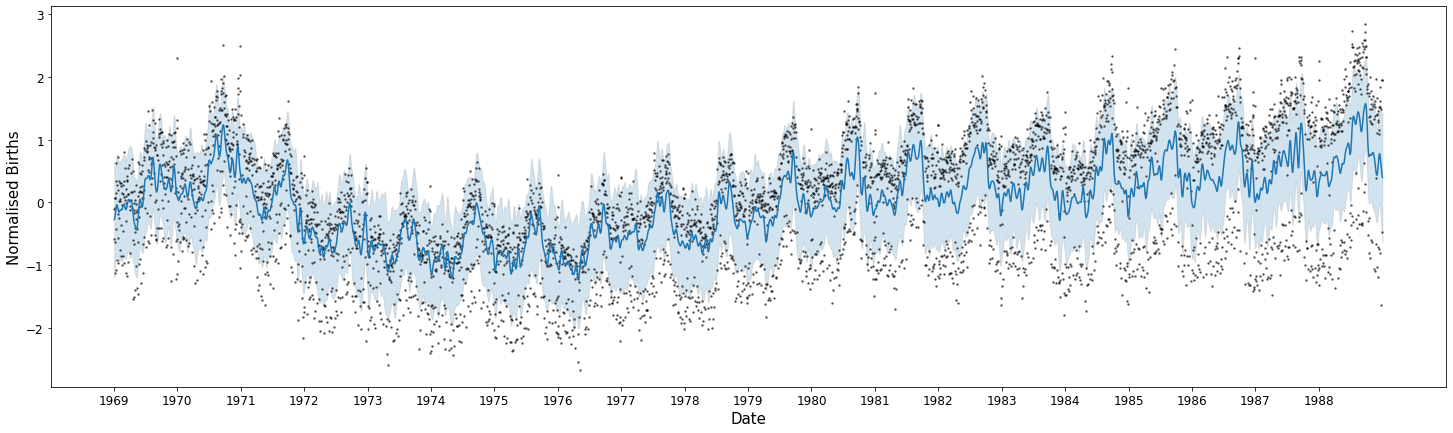

Test


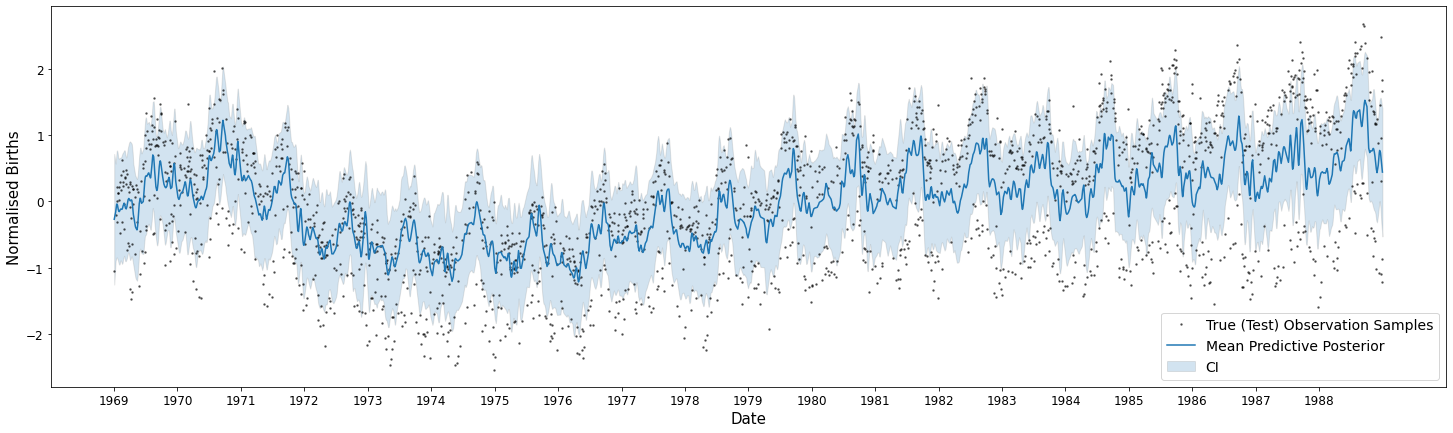

train ELBO, MSE, MAE:  -4077.733263590724 0.5332479169969222 0.613298965325451
test ELBO, MSE, MAE:  -4282.045049442615 0.6534500406143157 0.6809864795188081
percentage out of CI (train, test):  33.50283590846861 37.86496350364963


In [8]:
kernel = gpflow.kernels.RBF(lengthscales = 7, variance = 1)
M = 3000
Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
set_trainable(model.likelihood.variance, False)
model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(0.5), to_default_float(1))
model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

train_data = (x_train, y_train)
loss_fn = model.training_loss_closure(train_data) 

gpflow.utilities.set_trainable(model.q_mu, False)
gpflow.utilities.set_trainable(model.q_sqrt, False)

variational_vars = [(model.q_mu, model.q_sqrt)]
natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
adam_vars = model.trainable_variables
adam_opt = tf.optimizers.Adam(0.01)

@tf.function
def optimisation_step():
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)

epochs = 100
log_freq = 20

for epoch in range(1, epochs + 1):
    optimisation_step()

    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
        if epoch == 100:
            mean_train, var_train = model.predict_f(x_train)
            print('Train')
            plot_distribution(x_train, y_train, mean_train, var_train, pos, labels, legend=False)

# predict
mean_test, var_test = model.predict_f(x_test)
print('Test')
plot_distribution(x_test, y_test, mean_test, var_test, pos, labels)

# evaluate
print('train ELBO, MSE, MAE: ', model.elbo((x_train,y_train)).numpy(), mean_squared_error(y_train, mean_train), mean_absolute_error(y_train, mean_train))
print('test ELBO, MSE, MAE: ', model.elbo((x_test,y_test)).numpy(), mean_squared_error(y_test, mean_test), mean_absolute_error(y_test, mean_test))
print('percentage out of CI (train, test): ', percentage_outof_CI(y_train, mean_train, var_train), percentage_outof_CI(y_test, mean_test, var_test))

print_summary(model, fmt='notebook')